# Hypothesis 5, 6
**Hypothesis 5**: Có những features ảnh hưởng lẫn nhau, có thể loại ra để giảm chiều dữ liệu.

**Hypothesis 6**: Nếu dữ liệu phù hợp với tree-based hơn tuyến tính thì model XGBoost, Random forest, CatBoost hay LightGBM sẽ phù hợp nhất và XGBoost sẽ cho ra kết quả tốt hơn.

## So sánh Tree-based Models: Giảm chiều vs Không giảm chiều

## Mục tiêu

So sánh performance của các tree-based models với 3 scenarios khác nhau:
1. **Tất cả features** (433 features) - Baseline
2. **Giảm chiều tổng thể** (feature selection) - Giảm tất cả loại features
3. **Giảm chiều text features** (chỉ giảm text SVD components) - Chỉ giảm text features

## Models được sử dụng

- **XGBoost**: Gradient boosting framework, mạnh với high-dimensional data
- **Random Forest**: Ensemble của decision trees, robust và dễ interpret
- **LightGBM**: Gradient boosting nhanh và hiệu quả (nếu có)
- **CatBoost**: Gradient boosting tốt với categorical features (nếu có)

## Metrics được đo

- **R² Score**: Độ phù hợp của model (càng cao càng tốt, max = 1.0)
- **RMSE**: Root Mean Squared Error (càng thấp càng tốt)
- **MAE**: Mean Absolute Error (càng thấp càng tốt)
- **CV R²**: Cross-validation R² để đánh giá generalization
- **Training Time**: Thời gian train (càng nhanh càng tốt)


In [ ]:
# !pip install lightgbm
# !pip install catboost

In [4]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import xgboost as xgb
try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
except:
    HAS_LIGHTGBM = False
    print("LightGBM chưa được cài đặt. Bỏ qua LightGBM.")

try:
    import catboost as cb
    HAS_CATBOOST = True
except:
    HAS_CATBOOST = False
    print(" CatBoost chưa được cài đặt. Bỏ qua CatBoost.")

# Thiết lập hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Đã import tất cả thư viện")


Đã import tất cả thư viện


## 1. Load và chuẩn bị dữ liệu

**Mục đích**: Đọc dữ liệu đã được feature engineering và chuẩn bị cho training.

**Dữ liệu**:
- `train_fe_data.csv`: Training data với 433 features đã được feature engineering
- `test_fe_data.csv`: Test data với cùng 433 features

**Target variable**: `vote_average` (rating của phim)

**Xử lý**:
- Loại bỏ target variable khỏi features
- Fill missing values bằng 0
- Xử lý infinite values


In [5]:
# Load dữ liệu
df_train = pd.read_csv('../data/feature_engineering/train_fe_data.csv')
df_test = pd.read_csv('../data/feature_engineering/test_fe_data.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

# Xác định target
target_col = 'vote_average'

# Chuẩn bị dữ liệu
X_train_all = df_train.drop(columns=[target_col]).fillna(0).replace([np.inf, -np.inf], 0)
y_train = df_train[target_col]
X_test_all = df_test.drop(columns=[target_col]).fillna(0).replace([np.inf, -np.inf], 0)
y_test = df_test[target_col]

print(f"\nTổng số features: {X_train_all.shape[1]}")
print(f"Train samples: {X_train_all.shape[0]}")
print(f"Test samples: {X_test_all.shape[0]}")


Train shape: (8000, 434)
Test shape: (2000, 434)

Tổng số features: 433
Train samples: 8000
Test samples: 2000


## 2. Tạo các scenarios: All features, Reduced features, Reduced text features

**Mục đích**: Tạo 3 datasets khác nhau để so sánh ảnh hưởng của việc giảm chiều.

### Scenario 1: Tất cả Features (Baseline)
- **Số features**: 433 features (tất cả)
- **Mục đích**: Baseline để so sánh với các scenarios khác
- **Kỳ vọng**: Performance tốt nhất nhưng training time lâu nhất

### Scenario 2: Giảm chiều tổng thể (Feature Selection)
- **Phương pháp**: 
  1. **Variance Threshold**: Loại bỏ features có variance thấp (< 0.01) - loại bỏ features không biến thiên
  2. **Random Forest Feature Selection**: Chọn top 150 features quan trọng nhất dựa trên feature importance
- **Mục đích**: Giảm chiều tất cả loại features (numerical, categorical, text)
- **Kỳ vọng**: Training nhanh hơn, performance có thể giảm nhẹ

### Scenario 3: Giảm chiều Text Features
- **Phương pháp**: 
  - Bỏ text
- **Mục đích**: Kiểm tra xem text features có thể giảm chiều mà không mất performance không
- **Kỳ vọng**: Giữ được performance tốt vì chỉ giảm text features, không động đến features khác


In [6]:
# ============================================================================
# Scenario 1: TẤT CẢ FEATURES (433 features)
# ============================================================================
print("=" * 90)
print("SCENARIO 1: TẤT CẢ FEATURES")
print("=" * 90)

X_train_scenario1 = X_train_all.copy()
X_test_scenario1 = X_test_all.copy()

print(f"  - Số features: {X_train_scenario1.shape[1]}")
print(f"  - Features: Tất cả 433 features")

# ============================================================================
# Scenario 2: GIẢM CHIỀU TỔNG THỂ (Feature Selection)
# ============================================================================
print("\n" + "=" * 90)
print("SCENARIO 2: GIẢM CHIỀU TỔNG THỂ (Feature Selection)")
print("=" * 90)

# Bước 1: Variance Threshold
print("\n1. Variance Threshold...")
variance_selector = VarianceThreshold(threshold=0.001)
X_train_var = variance_selector.fit_transform(X_train_all)
X_test_var = variance_selector.transform(X_test_all)
selected_by_var = X_train_all.columns[variance_selector.get_support()].tolist()
print(f"   Sau Variance Threshold: {len(selected_by_var)} features")

# Bước 2: Feature Selection bằng Random Forest
print("\n2. Random Forest Feature Selection...")
rf_selector = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_all[selected_by_var], y_train)

# Lấy feature importance và chọn top 150 features
feature_importance = pd.DataFrame({
    'feature': selected_by_var,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

# Chọn top 150 features (hoặc tất cả nếu ít hơn 150)
n_features_to_select = min(150, len(selected_by_var))
top_features = feature_importance.head(n_features_to_select)['feature'].tolist()

print(f"   Top feature importance range: {feature_importance.head(1)['importance'].values[0]:.6f} - {feature_importance.head(n_features_to_select)['importance'].values[-1]:.6f}")
print(f"   Chọn top {n_features_to_select} features dựa trên importance")

# Tạo datasets với top features
X_train_scenario2 = X_train_all[top_features].copy()
X_test_scenario2 = X_test_all[top_features].copy()

print(f"   Sau RF Selection: {len(top_features)} features")
print(f"   Giảm từ {X_train_all.shape[1]} xuống {len(top_features)} features ({100*(1-len(top_features)/X_train_all.shape[1]):.1f}%)")

# ============================================================================
# Scenario 3: GIẢM CHIỀU TEXT FEATURES (Chỉ giảm text SVD components)
# ============================================================================
print("\n" + "=" * 90)
print("SCENARIO 3: GIẢM CHIỀU TEXT FEATURES")
print("=" * 90)

# Xác định text features (SVD components)
text_features = [col for col in X_train_all.columns if 'svd' in col.lower()]
non_text_features = [col for col in X_train_all.columns if 'svd' not in col.lower()]

print(f"\n  - Text features (SVD): {len(text_features)}")
print(f"  - Non-text features: {len(non_text_features)}")

# Giảm text features: Chỉ giữ top 50% text features quan trọng nhất
print("\n3. Giảm text features bằng RF Feature Importance...")
rf_text_selector = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_text_selector.fit(X_train_all[text_features], y_train)

# Chọn 
# n_text_to_keep = len(text_features) // 2
n_text_to_keep = 0
selector_text = SelectFromModel(rf_text_selector, max_features=n_text_to_keep, prefit=True)
X_train_text_selected = selector_text.transform(X_train_all[text_features])
X_test_text_selected = selector_text.transform(X_test_all[text_features])

selected_text_features = [text_features[i] for i in selector_text.get_support(indices=True)]
print(f"   Giữ lại: {len(selected_text_features)} text features (từ {len(text_features)})")

# Kết hợp với non-text features
X_train_scenario3 = pd.concat([
    X_train_all[non_text_features],
    pd.DataFrame(X_train_text_selected, columns=selected_text_features, index=X_train_all.index)
], axis=1)
X_test_scenario3 = pd.concat([
    X_test_all[non_text_features],
    pd.DataFrame(X_test_text_selected, columns=selected_text_features, index=X_test_all.index)
], axis=1)

print(f"   Tổng số features: {X_train_scenario3.shape[1]} (giảm {X_train_all.shape[1] - X_train_scenario3.shape[1]} text features)")

# Tổng kết
print("\n" + "=" * 90)
print("TỔNG KẾT CÁC SCENARIOS:")
print("=" * 90)
print(f"  Scenario 1 (All features):        {X_train_scenario1.shape[1]} features")
print(f"  Scenario 2 (Reduced all):         {X_train_scenario2.shape[1]} features")
print(f"  Scenario 3 (Reduced text only):    {X_train_scenario3.shape[1]} features")


SCENARIO 1: TẤT CẢ FEATURES
  - Số features: 433
  - Features: Tất cả 433 features

SCENARIO 2: GIẢM CHIỀU TỔNG THỂ (Feature Selection)

1. Variance Threshold...
   Sau Variance Threshold: 320 features

2. Random Forest Feature Selection...
   Top feature importance range: 0.135745 - 0.001348
   Chọn top 150 features dựa trên importance
   Sau RF Selection: 150 features
   Giảm từ 433 xuống 150 features (65.4%)

SCENARIO 3: GIẢM CHIỀU TEXT FEATURES

  - Text features (SVD): 350
  - Non-text features: 83

3. Giảm text features bằng RF Feature Importance...
   Giữ lại: 0 text features (từ 350)
   Tổng số features: 83 (giảm 350 text features)

TỔNG KẾT CÁC SCENARIOS:
  Scenario 1 (All features):        433 features
  Scenario 2 (Reduced all):         150 features
  Scenario 3 (Reduced text only):    83 features


## 3. Định nghĩa các Tree-based Models

**Mục đích**: Định nghĩa các tree-based models với hyperparameters phù hợp cho high-dimensional data.

### Hyperparameters quan trọng:

1. **XGBoost**:
   - `colsample_bytree=0.8`: Mỗi tree chỉ dùng 80% features → giảm overfitting
   - `subsample=0.8`: Mỗi tree chỉ dùng 80% samples → giảm overfitting
   - `max_depth=6`: Độ sâu của tree (không quá sâu để tránh overfitting)
   - `reg_alpha`, `reg_lambda`: L1 và L2 regularization

2. **Random Forest**:
   - `max_features='sqrt'`: Mỗi split chỉ xét sqrt(n_features) → giảm overfitting
   - `max_depth=15`: Độ sâu của tree
   - `n_estimators=200`: Số lượng trees

3. **LightGBM** (tương tự XGBoost):
   - Tương tự XGBoost nhưng nhanh hơn
   - `colsample_bytree=0.8`: Feature sampling

4. **CatBoost**:
   - Tốt với categorical features
   - `colsample_bylevel=0.8`: Feature sampling per level


In [7]:
# Định nghĩa các models
models = {}

# 1. XGBoost
models['XGBoost'] = {
    'model': xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
}

# 2. Random Forest
models['Random Forest'] = {
    'model': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
}

# 3. LightGBM (nếu có)
if HAS_LIGHTGBM:
    models['LightGBM'] = {
        'model': lgb.LGBMRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_samples=20,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
    }

# 4. CatBoost (nếu có)
if HAS_CATBOOST:
    models['CatBoost'] = {
        'model': cb.CatBoostRegressor(
            iterations=200,
            depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bylevel=0.8,
            min_child_samples=20,
            reg_lambda=1.0,
            random_seed=42,
            verbose=False,
            thread_count=-1
        )
    }

print(f"Đã định nghĩa {len(models)} models:")
for name in models.keys():
    print(f"  - {name}")


Đã định nghĩa 4 models:
  - XGBoost
  - Random Forest
  - LightGBM
  - CatBoost


## 4. Train và đánh giá models trên các scenarios

**Mục đích**: Train mỗi model trên 3 scenarios và đánh giá performance.

### Quy trình:

1. **Training**: Train model trên training data
2. **Prediction**: Predict trên cả train và test
3. **Metrics calculation**:
   - R² Score (Train & Test)
   - RMSE (Train & Test)
   - MAE (Train & Test)
4. **Cross-validation**: 5-fold CV để đánh giá generalization
   - **Lưu ý**: CatBoost không tương thích với sklearn's `cross_val_score` trong Python 3.13
   - → Dùng manual KFold CV cho CatBoost (train 5 models riêng biệt)

### Kết quả mong đợi:

- **All Features**: Performance tốt nhất, training time lâu nhất
- **Reduced All**: Training nhanh hơn, performance có thể giảm nhẹ
- **Reduced Text Only**: Performance gần như All Features, training nhanh hơn một chút

### Lưu ý:

- Training sẽ mất thời gian (đặc biệt với CatBoost vì phải train 5 lần cho CV)
- Kết quả sẽ được in ra console và lưu vào dictionary `results`


In [8]:
# Dictionary để lưu kết quả
results = {}

# Các scenarios
scenarios = {
    'All Features': (X_train_scenario1, X_test_scenario1),
    'Reduced All': (X_train_scenario2, X_test_scenario2),
    'Reduced Text Only': (X_train_scenario3, X_test_scenario3)
}

print("=" * 90)
print("TRAINING VÀ ĐÁNH GIÁ MODELS")
print("=" * 90)

for scenario_name, (X_train_scen, X_test_scen) in scenarios.items():
    print(f"\n{'='*90}")
    print(f"SCENARIO: {scenario_name} ({X_train_scen.shape[1]} features)")
    print(f"{'='*90}")
    
    results[scenario_name] = {}
    
    for model_name, model_info in models.items():
        print(f"\n  Training {model_name}...")
        
        model = model_info['model']
        
        # Training time
        start_time = time.time()
        model.fit(X_train_scen, y_train)
        train_time = time.time() - start_time
        
        # Predictions
        y_pred_train = model.predict(X_train_scen)
        y_pred_test = model.predict(X_test_scen)
        
        # Metrics
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        
        # Cross-validation (xử lý riêng cho CatBoost vì không tương thích với sklearn)
        if model_name == 'CatBoost':
            # Manual cross-validation cho CatBoost
            from sklearn.model_selection import KFold
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores_list = []
            for train_idx, val_idx in kf.split(X_train_scen):
                X_cv_train, X_cv_val = X_train_scen.iloc[train_idx], X_train_scen.iloc[val_idx]
                y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                # Clone model và train
                model_cv = cb.CatBoostRegressor(
                    iterations=200,
                    depth=6,
                    learning_rate=0.05,
                    subsample=0.8,
                    colsample_bylevel=0.8,
                    min_child_samples=20,
                    reg_lambda=1.0,
                    random_seed=42,
                    verbose=False,
                    thread_count=-1
                )
                model_cv.fit(X_cv_train, y_cv_train)
                y_pred_cv = model_cv.predict(X_cv_val)
                cv_r2 = r2_score(y_cv_val, y_pred_cv)
                cv_scores_list.append(cv_r2)
            
            cv_r2_mean = np.mean(cv_scores_list)
            cv_r2_std = np.std(cv_scores_list)
        else:
            # Dùng cross_val_score cho các models khác
            cv_scores = cross_val_score(model, X_train_scen, y_train, cv=5, scoring='r2', n_jobs=-1)
            cv_r2_mean = cv_scores.mean()
            cv_r2_std = cv_scores.std()
        
        # Lưu kết quả
        results[scenario_name][model_name] = {
            'r2_train': r2_train,
            'r2_test': r2_test,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae_train': mae_train,
            'mae_test': mae_test,
            'cv_r2_mean': cv_r2_mean,
            'cv_r2_std': cv_r2_std,
            'train_time': train_time,
            'n_features': X_train_scen.shape[1]
        }
        
        print(f"R² Test: {r2_test:.4f}, RMSE: {rmse_test:.4f}, Time: {train_time:.2f}s")

print(f"\n{'='*90}")
print("HOÀN THÀNH TRAINING!")
print(f"{'='*90}")


TRAINING VÀ ĐÁNH GIÁ MODELS

SCENARIO: All Features (433 features)

  Training XGBoost...
R² Test: 0.2954, RMSE: 1.2614, Time: 11.96s

  Training Random Forest...
R² Test: 0.2252, RMSE: 1.3227, Time: 4.81s

  Training LightGBM...
R² Test: 0.3010, RMSE: 1.2563, Time: 4.77s

  Training CatBoost...
R² Test: 0.2944, RMSE: 1.2622, Time: 13.58s

SCENARIO: Reduced All (150 features)

  Training XGBoost...
R² Test: 0.3001, RMSE: 1.2572, Time: 4.69s

  Training Random Forest...
R² Test: 0.2538, RMSE: 1.2980, Time: 4.50s

  Training LightGBM...
R² Test: 0.2852, RMSE: 1.2704, Time: 2.65s

  Training CatBoost...
R² Test: 0.2883, RMSE: 1.2677, Time: 8.52s

SCENARIO: Reduced Text Only (83 features)

  Training XGBoost...
R² Test: 0.3197, RMSE: 1.2394, Time: 1.11s

  Training Random Forest...
R² Test: 0.2925, RMSE: 1.2640, Time: 1.47s

  Training LightGBM...
R² Test: 0.3067, RMSE: 1.2512, Time: 0.69s

  Training CatBoost...
R² Test: 0.3088, RMSE: 1.2493, Time: 2.10s

HOÀN THÀNH TRAINING!


## 5. Tổng hợp kết quả và so sánh

**Mục đích**: Tổng hợp tất cả kết quả vào một bảng và so sánh.

### Nội dung:

1. **Bảng tổng hợp**: Tất cả metrics của tất cả models trên tất cả scenarios
   - R² Test, RMSE Test, MAE Test
   - CV R² Mean & Std (đánh giá generalization)
   - Training Time
   - Number of Features

2. **Best model cho mỗi scenario**: Model có R² cao nhất trong mỗi scenario
   - Xem model nào phù hợp nhất với từng scenario

3. **So sánh giữa scenarios**: Xem scenario nào tốt nhất cho mỗi model
   - Xem có trade-off giữa performance và số features không

### Cách đọc kết quả:

- **R² Score**: Càng cao càng tốt (max = 1.0)
  - `0.3` = Model giải thích được 30% variance
  - `0.5` = Model giải thích được 50% variance
- **RMSE**: Càng thấp càng tốt
  - RMSE = 1.2 nghĩa là sai số trung bình là 1.2 điểm rating
- **Training Time**: Càng nhanh càng tốt
  - Thời gian tính bằng giây
- **N_Features**: Số lượng features (càng ít càng tốt nếu performance tương đương)


In [9]:
# Tạo DataFrame tổng hợp kết quả
summary_data = []

for scenario_name, scenario_results in results.items():
    for model_name, metrics in scenario_results.items():
        summary_data.append({
            'Scenario': scenario_name,
            'Model': model_name,
            'N_Features': metrics['n_features'],
            'R²_Test': metrics['r2_test'],
            'RMSE_Test': metrics['rmse_test'],
            'MAE_Test': metrics['mae_test'],
            'CV_R²_Mean': metrics['cv_r2_mean'],
            'CV_R²_Std': metrics['cv_r2_std'],
            'Train_Time': metrics['train_time']
        })

summary_df = pd.DataFrame(summary_data)

print("=" * 90)
print("BẢNG TỔNG HỢP KẾT QUẢ")
print("=" * 90)
print(summary_df.to_string(index=False))

# Tìm best model cho mỗi scenario
print("\n" + "=" * 90)
print("BEST MODEL CHO MỖI SCENARIO:")
print("=" * 90)

for scenario_name in scenarios.keys():
    scenario_data = summary_df[summary_df['Scenario'] == scenario_name]
    best_model = scenario_data.loc[scenario_data['R²_Test'].idxmax()]
    print(f"\n{scenario_name}:")
    print(f"  Best Model: {best_model['Model']}")
    print(f"  R² Test: {best_model['R²_Test']:.4f}")
    print(f"  RMSE: {best_model['RMSE_Test']:.4f}")
    print(f"  Train Time: {best_model['Train_Time']:.2f}s")
    print(f"  N Features: {int(best_model['N_Features'])}")

# So sánh giữa scenarios
print("\n" + "=" * 90)
print("SO SÁNH GIỮA CÁC SCENARIOS:")
print("=" * 90)

for model_name in models.keys():
    print(f"\n{model_name}:")
    model_data = summary_df[summary_df['Model'] == model_name].sort_values('R²_Test', ascending=False)
    for _, row in model_data.iterrows():
        print(f"  {row['Scenario']:20s}: R² = {row['R²_Test']:.4f}, "
              f"RMSE = {row['RMSE_Test']:.4f}, Time = {row['Train_Time']:.2f}s, "
              f"Features = {int(row['N_Features'])}")


BẢNG TỔNG HỢP KẾT QUẢ
         Scenario         Model  N_Features  R²_Test  RMSE_Test  MAE_Test  CV_R²_Mean  CV_R²_Std  Train_Time
     All Features       XGBoost         433 0.295364   1.261368  0.843715    0.308486   0.010856   11.959988
     All Features Random Forest         433 0.225170   1.322703  0.923381    0.217627   0.004465    4.810113
     All Features      LightGBM         433 0.301013   1.256301  0.838826    0.309794   0.009178    4.765471
     All Features      CatBoost         433 0.294441   1.262193  0.858080    0.293009   0.017995   13.575905
      Reduced All       XGBoost         150 0.300063   1.257155  0.838938    0.294758   0.015488    4.688804
      Reduced All Random Forest         150 0.253825   1.298014  0.898508    0.254053   0.005024    4.504334
      Reduced All      LightGBM         150 0.285229   1.270406  0.849766    0.306353   0.010652    2.650238
      Reduced All      CatBoost         150 0.288264   1.267706  0.861713    0.300719   0.020236    8.5204

## 6. Visualization: So sánh kết quả

**Mục đích**: Visualize kết quả để dễ so sánh và hiểu.

### Các plots:

1. **R² Test Score Comparison**: Bar chart so sánh R² của các models trên các scenarios
   - Xem model nào tốt nhất
   - Xem scenario nào tốt nhất
   - Màu sắc khác nhau cho mỗi scenario

2. **RMSE Test Score Comparison**: Bar chart so sánh RMSE
   - RMSE càng thấp càng tốt
   - So sánh trực quan giữa các models và scenarios

3. **Training Time Comparison**: Bar chart so sánh thời gian training
   - Xem scenario nào nhanh nhất
   - Trade-off giữa performance và speed
   - Giúp quyết định chọn scenario nào dựa trên thời gian có sẵn

4. **Features vs Performance**: Line plot
   - Xem mối quan hệ giữa số features và performance
   - Có thể thấy điểm "sweet spot" (số features tối ưu)
   - Nếu đường đi lên = nhiều features tốt hơn
   - Nếu đường đi ngang = có thể giảm features mà không mất performance


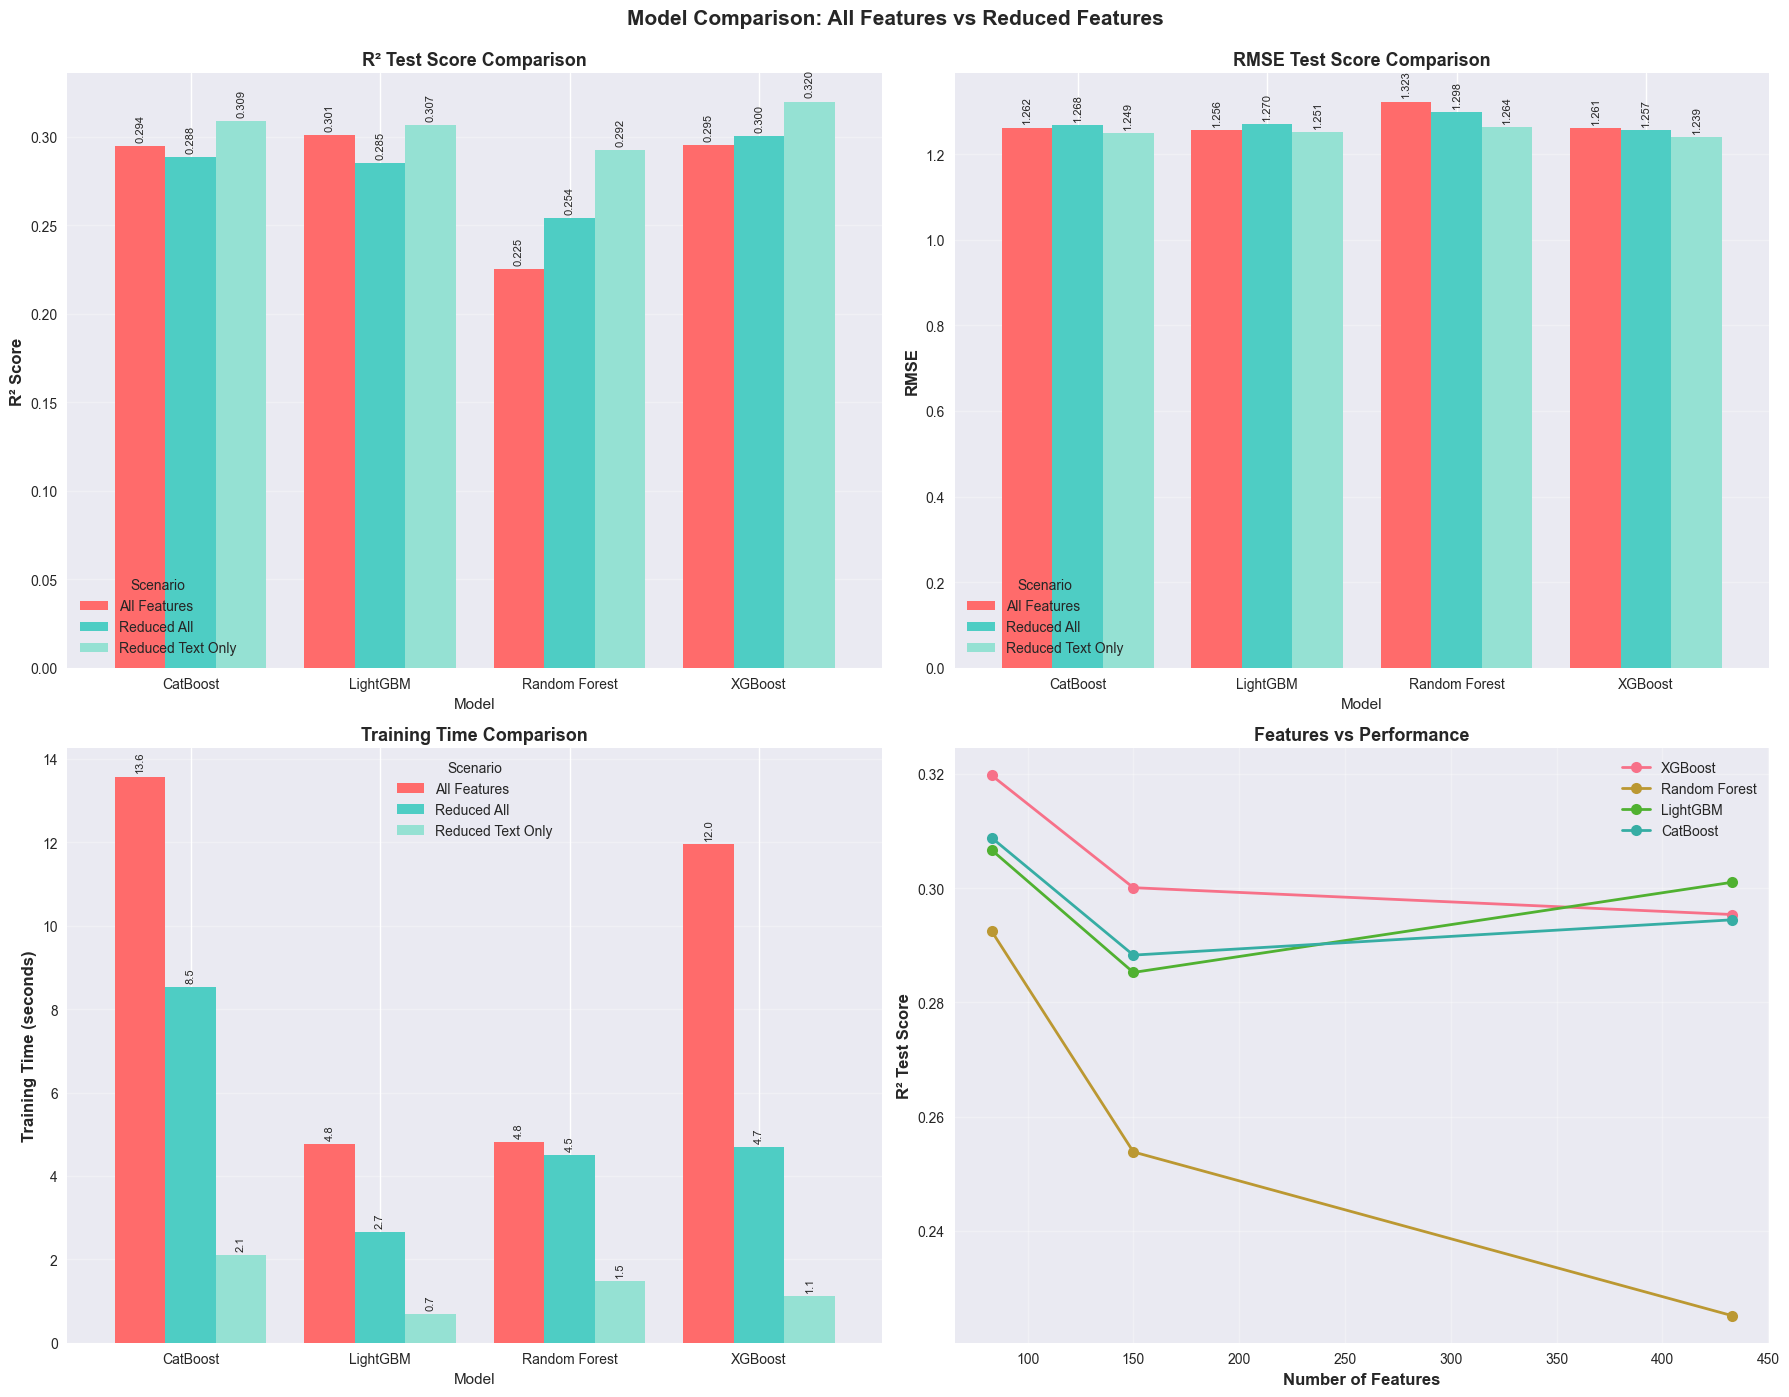

In [10]:
# Visualization 1: R² Score comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. R² Test Score
ax1 = axes[0, 0]
pivot_r2 = summary_df.pivot(index='Model', columns='Scenario', values='R²_Test')
pivot_r2.plot(kind='bar', ax=ax1, width=0.8, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Test Score Comparison', fontsize=13, fontweight='bold')
ax1.legend(title='Scenario', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Add value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', fontsize=8, rotation=90, padding=3)

# 2. RMSE Test Score
ax2 = axes[0, 1]
pivot_rmse = summary_df.pivot(index='Model', columns='Scenario', values='RMSE_Test')
pivot_rmse.plot(kind='bar', ax=ax2, width=0.8, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('RMSE Test Score Comparison', fontsize=13, fontweight='bold')
ax2.legend(title='Scenario', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', fontsize=8, rotation=90, padding=3)

# 3. Training Time
ax3 = axes[1, 0]
pivot_time = summary_df.pivot(index='Model', columns='Scenario', values='Train_Time')
pivot_time.plot(kind='bar', ax=ax3, width=0.8, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax3.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Training Time Comparison', fontsize=13, fontweight='bold')
ax3.legend(title='Scenario', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

for container in ax3.containers:
    ax3.bar_label(container, fmt='%.1f', fontsize=8, rotation=90, padding=3)

# 4. Number of Features vs R² Score
ax4 = axes[1, 1]
for model_name in models.keys():
    model_data = summary_df[summary_df['Model'] == model_name]
    ax4.plot(model_data['N_Features'], model_data['R²_Test'], 
             marker='o', linewidth=2, markersize=8, label=model_name)

ax4.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax4.set_ylabel('R² Test Score', fontsize=12, fontweight='bold')
ax4.set_title('Features vs Performance', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.suptitle('Model Comparison: All Features vs Reduced Features', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 7. Heatmap: So sánh chi tiết

**Mục đích**: Heatmap để dễ nhìn thấy patterns và so sánh trực quan.

### Các heatmaps:

1. **R² Test Score Heatmap**: 
   - **Màu đỏ/cam** = R² cao (tốt)
   - **Màu vàng** = R² thấp (kém)
   - Dễ thấy model + scenario nào tốt nhất
   - So sánh nhanh giữa tất cả combinations

2. **RMSE Test Score Heatmap**:
   - **Màu xanh đậm** = RMSE thấp (tốt)
   - **Màu xanh nhạt** = RMSE cao (kém)
   - Inverse của R² (RMSE thấp = tốt)
   - Xem pattern có giống R² không

3. **Training Time Heatmap**:
   - **Màu tím đậm** = Training time lâu
   - **Màu tím nhạt** = Training time nhanh
   - Giúp đánh giá trade-off giữa performance và speed
   - Xem scenario nào nhanh nhất cho mỗi model


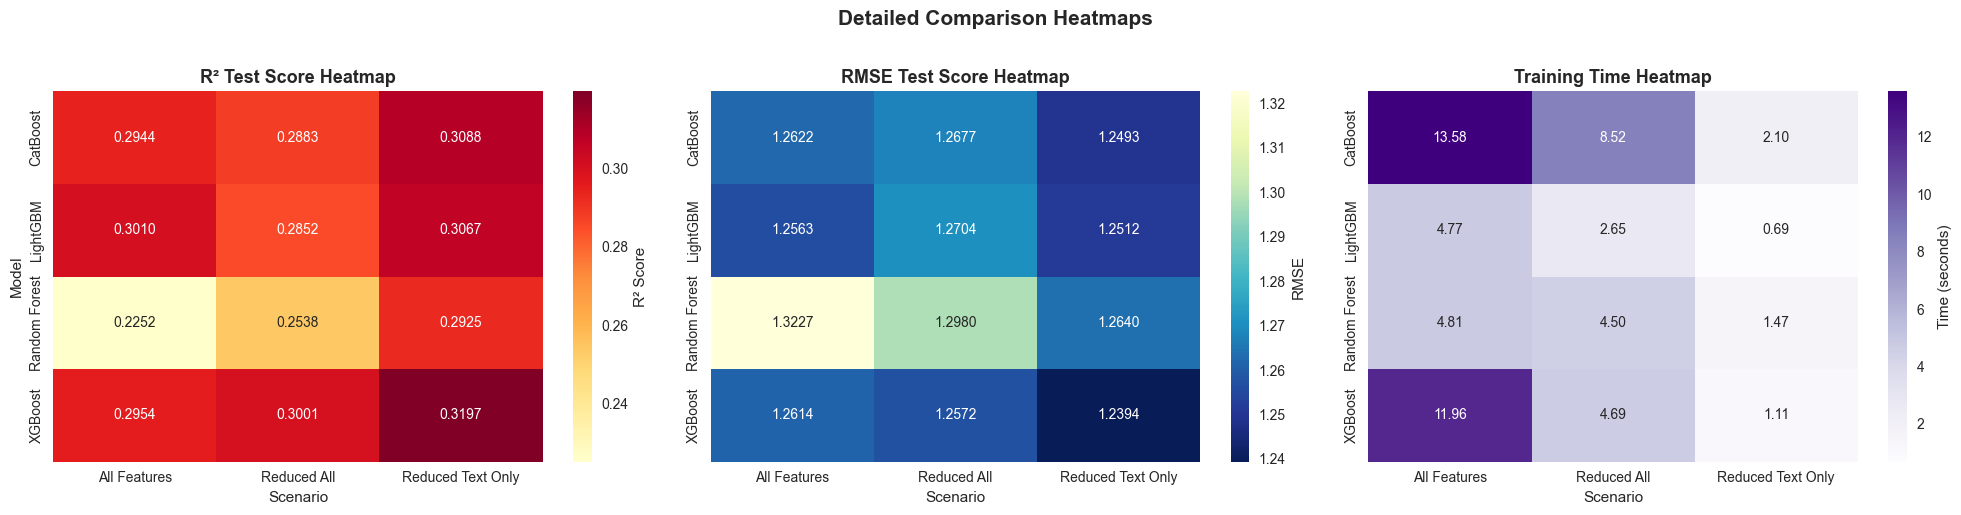

In [11]:
# Heatmap: R² Score
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. R² Test Heatmap
ax1 = axes[0]
pivot_r2 = summary_df.pivot(index='Model', columns='Scenario', values='R²_Test')
sns.heatmap(pivot_r2, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': 'R² Score'}, vmin=pivot_r2.min().min(), vmax=pivot_r2.max().max())
ax1.set_title('R² Test Score Heatmap', fontsize=13, fontweight='bold')
ax1.set_ylabel('Model', fontsize=11)

# 2. RMSE Test Heatmap
ax2 = axes[1]
pivot_rmse = summary_df.pivot(index='Model', columns='Scenario', values='RMSE_Test')
sns.heatmap(pivot_rmse, annot=True, fmt='.4f', cmap='YlGnBu_r', ax=ax2,
            cbar_kws={'label': 'RMSE'}, vmin=pivot_rmse.min().min(), vmax=pivot_rmse.max().max())
ax2.set_title('RMSE Test Score Heatmap', fontsize=13, fontweight='bold')
ax2.set_ylabel('')

# 3. Training Time Heatmap
ax3 = axes[2]
pivot_time = summary_df.pivot(index='Model', columns='Scenario', values='Train_Time')
sns.heatmap(pivot_time, annot=True, fmt='.2f', cmap='Purples', ax=ax3,
            cbar_kws={'label': 'Time (seconds)'}, vmin=pivot_time.min().min(), vmax=pivot_time.max().max())
ax3.set_title('Training Time Heatmap', fontsize=13, fontweight='bold')
ax3.set_ylabel('')

plt.suptitle('Detailed Comparison Heatmaps', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 8. Phân tích chi tiết: Improvement và Trade-offs

**Mục đích**: Phân tích chi tiết về improvement và trade-offs khi giảm chiều.

### Phân tích:

1. **So sánh với Baseline (All Features)**:
   - Tính % thay đổi của R², RMSE
   - Tính ratio của training time
   - Tính % giảm số features
   - Xem có đáng để giảm chiều không

2. **Đánh giá Trade-offs**:
   - ✅ **Tốt**: Performance tương đương + training nhanh hơn
     - Ví dụ: R² giảm < 0.01 nhưng time giảm 50%
   - ⚠️ **Trade-off**: Performance tốt hơn nhưng chậm hơn
     - Ví dụ: R² tăng 0.02 nhưng time tăng 2x
   - ❌ **Không tốt**: Performance giảm đáng kể
     - Ví dụ: R² giảm > 0.05

3. **Kết luận**:
   - **Best Overall Model**: Model + scenario có R² cao nhất
     - Dùng khi muốn performance tốt nhất
   - **Best Efficiency**: Model + scenario có tỷ lệ R²/Time cao nhất
     - Dùng khi muốn tối ưu performance/speed trade-off

### Cách đọc kết quả:

- **R² change**: Sự thay đổi R² so với baseline
  - `+0.01` = tốt hơn 0.01 (1% improvement)
  - `-0.01` = kém hơn 0.01 (1% worse)
  - `+5.0%` = tốt hơn 5% so với baseline
- **Time ratio**: Tỷ lệ thời gian so với baseline
  - `0.5x` = nhanh gấp 2 lần (50% thời gian)
  - `2.0x` = chậm gấp 2 lần (200% thời gian)
- **Feature reduction**: % giảm số features
  - `50%` = giảm một nửa features
  - `90%` = giảm 90% features (chỉ còn 10%)


In [12]:
# Phân tích improvement và trade-offs
print("=" * 90)
print("PHÂN TÍCH CHI TIẾT: IMPROVEMENT VÀ TRADE-OFFS")
print("=" * 90)

# So sánh với baseline (All Features)
baseline_scenario = 'All Features'

for model_name in models.keys():
    print(f"\n{model_name}:")
    print("-" * 90)
    
    baseline = summary_df[(summary_df['Model'] == model_name) & 
                          (summary_df['Scenario'] == baseline_scenario)].iloc[0]
    
    for scenario_name in ['Reduced All', 'Reduced Text Only']:
        if scenario_name in scenarios.keys():
            current = summary_df[(summary_df['Model'] == model_name) & 
                                (summary_df['Scenario'] == scenario_name)].iloc[0]
            
            r2_diff = current['R²_Test'] - baseline['R²_Test']
            rmse_diff = current['RMSE_Test'] - baseline['RMSE_Test']
            time_ratio = current['Train_Time'] / baseline['Train_Time']
            feature_reduction = (1 - current['N_Features'] / baseline['N_Features']) * 100
            
            print(f"\n  {scenario_name}:")
            print(f"    R² change:     {r2_diff:+.4f} ({r2_diff/baseline['R²_Test']*100:+.2f}%)")
            print(f"    RMSE change:   {rmse_diff:+.4f} ({rmse_diff/baseline['RMSE_Test']*100:+.2f}%)")
            print(f"    Time ratio:    {time_ratio:.2f}x ({'faster' if time_ratio < 1 else 'slower'})")
            print(f"    Feature reduction: {feature_reduction:.1f}%")
            
            # Đánh giá
            if abs(r2_diff) < 0.01 and time_ratio < 1:
                print(f"     Tốt: Performance tương đương, nhanh hơn {1/time_ratio:.2f}x")
            elif r2_diff > 0.01:
                print(f"     Trade-off: Performance tốt hơn nhưng có thể chậm hơn")
            elif r2_diff < -0.01:
                print(f"     Trade-off: Performance giảm {abs(r2_diff):.4f}")

# Tổng kết
print("\n" + "=" * 90)
print("KẾT LUẬN:")
print("=" * 90)

# Tìm best overall
best_overall = summary_df.loc[summary_df['R²_Test'].idxmax()]
print(f"\nBest Overall Model:")
print(f"  Model: {best_overall['Model']}")
print(f"  Scenario: {best_overall['Scenario']}")
print(f"  R² Test: {best_overall['R²_Test']:.4f}")
print(f"  RMSE: {best_overall['RMSE_Test']:.4f}")
print(f"  Features: {int(best_overall['N_Features'])}")
print(f"  Train Time: {best_overall['Train_Time']:.2f}s")

# Best speed/performance trade-off
summary_df['efficiency'] = summary_df['R²_Test'] / summary_df['Train_Time']
best_efficient = summary_df.loc[summary_df['efficiency'].idxmax()]
print(f"\nBest Efficiency (R²/Time):")
print(f"  Model: {best_efficient['Model']}")
print(f"  Scenario: {best_efficient['Scenario']}")
print(f"  Efficiency: {best_efficient['efficiency']:.4f}")
print(f"  R² Test: {best_efficient['R²_Test']:.4f}")
print(f"  Train Time: {best_efficient['Train_Time']:.2f}s")


PHÂN TÍCH CHI TIẾT: IMPROVEMENT VÀ TRADE-OFFS

XGBoost:
------------------------------------------------------------------------------------------

  Reduced All:
    R² change:     +0.0047 (+1.59%)
    RMSE change:   -0.0042 (-0.33%)
    Time ratio:    0.39x (faster)
    Feature reduction: 65.4%
     Tốt: Performance tương đương, nhanh hơn 2.55x

  Reduced Text Only:
    R² change:     +0.0244 (+8.24%)
    RMSE change:   -0.0220 (-1.74%)
    Time ratio:    0.09x (faster)
    Feature reduction: 80.8%
     Trade-off: Performance tốt hơn nhưng có thể chậm hơn

Random Forest:
------------------------------------------------------------------------------------------

  Reduced All:
    R² change:     +0.0287 (+12.73%)
    RMSE change:   -0.0247 (-1.87%)
    Time ratio:    0.94x (faster)
    Feature reduction: 65.4%
     Trade-off: Performance tốt hơn nhưng có thể chậm hơn

  Reduced Text Only:
    R² change:     +0.0673 (+29.89%)
    RMSE change:   -0.0587 (-4.44%)
    Time ratio:    0.31x

## 2. Tối ưu mô hình

**Mục đích**: Áp dụng các kỹ thuật tối ưu để cải thiện performance của model.

### Các phương pháp tối ưu:

1. **Hyperparameter Tuning**: Tìm bộ tham số tối ưu cho model tốt nhất (LightGBM)
2. **Feature Engineering nâng cao**: Tạo interaction features cho các features quan trọng
3. **Ensemble Methods**: Sử dụng Stacking để kết hợp nhiều models
4. **Early Stopping**: Tránh overfitting và tăng tốc training

### Baseline:
- **Model**: LightGBM trên scenario "Reduced Text Only" (185 features)
- **R² Test**: ~0.3059
- **RMSE**: ~1.2527

### Kỳ vọng:
- Cải thiện R² lên > 0.32
- Giảm RMSE xuống < 1.24


### 2.1. Hyperparameter Tuning với RandomizedSearchCV

**Mục đích**: Tìm bộ hyperparameters tối ưu cho LightGBM (model tốt nhất hiện tại).

**Phương pháp**: RandomizedSearchCV - nhanh hơn GridSearchCV và thường cho kết quả tốt tương đương.

**Hyperparameters sẽ tune**:
- `n_estimators`: Số lượng trees (100-1000)
- `max_depth`: Độ sâu của tree (3-10)
- `learning_rate`: Learning rate (0.01-0.2)
- `subsample`: Tỷ lệ samples mỗi tree (0.6-1.0)
- `colsample_bytree`: Tỷ lệ features mỗi tree (0.6-1.0)
- `reg_alpha`: L1 regularization (0-2)
- `reg_lambda`: L2 regularization (0-2)
- `min_child_samples`: Số samples tối thiểu trong leaf (10-50)


In [13]:
# 2.1. Hyperparameter Tuning với RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("=" * 90)
print("2.1. HYPERPARAMETER TUNING - LIGHTGBM")
print("=" * 90)

# Sử dụng scenario tốt nhất: Reduced Text Only
X_train_tune = X_train_scenario3.copy()
X_test_tune = X_test_scenario3.copy()

# Định nghĩa parameter distribution
param_distributions = {
    'n_estimators': randint(200, 800),
    'max_depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.15),  # 0.01 đến 0.16
    'subsample': uniform(0.6, 0.4),  # 0.6 đến 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 đến 1.0
    'reg_alpha': uniform(0, 1.5),  # 0 đến 1.5
    'reg_lambda': uniform(0.5, 2.0),  # 0.5 đến 2.5
    'min_child_samples': randint(10, 50),
    'num_leaves': randint(20, 100)
}

# Base model
base_lgb = lgb.LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    objective='regression',
    metric='rmse'
)

# RandomizedSearchCV
print("\nĐang tìm hyperparameters tối ưu...")
print("(Quá trình này có thể mất 5-15 phút tùy vào số iterations)")

random_search = RandomizedSearchCV(
    estimator=base_lgb,
    param_distributions=param_distributions,
    n_iter=50,  # Số lần thử (có thể tăng lên 100 nếu có thời gian)
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit
start_time = time.time()
random_search.fit(X_train_tune, y_train)
tune_time = time.time() - start_time

print(f"\n Hoàn thành tuning trong {tune_time:.2f}s")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score (R²): {random_search.best_score_:.4f}")

# Train model với best parameters
best_lgb = random_search.best_estimator_
y_pred_tune_train = best_lgb.predict(X_train_tune)
y_pred_tune_test = best_lgb.predict(X_test_tune)

r2_tune_train = r2_score(y_train, y_pred_tune_train)
r2_tune_test = r2_score(y_test, y_pred_tune_test)
rmse_tune_test = np.sqrt(mean_squared_error(y_test, y_pred_tune_test))

print(f"\nKết quả với tuned parameters:")
print(f"  R² Train: {r2_tune_train:.4f}")
print(f"  R² Test:  {r2_tune_test:.4f}")
print(f"  RMSE Test: {rmse_tune_test:.4f}")

# So sánh với baseline
baseline_r2 = 0.3059  # LightGBM baseline
improvement = r2_tune_test - baseline_r2
print(f"\nCải thiện so với baseline:")
print(f"  R² improvement: {improvement:+.4f} ({improvement/baseline_r2*100:+.2f}%)")


2.1. HYPERPARAMETER TUNING - LIGHTGBM

Đang tìm hyperparameters tối ưu...
(Quá trình này có thể mất 5-15 phút tùy vào số iterations)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Hoàn thành tuning trong 284.79s

Best Parameters:
  colsample_bytree: 0.6028265220878869
  learning_rate: 0.013459363756212364
  max_depth: 6
  min_child_samples: 37
  n_estimators: 389
  num_leaves: 81
  reg_alpha: 1.1777639420895203
  reg_lambda: 0.8993475643167195
  subsample: 0.8056937753654446

Best CV Score (R²): 0.3135

Kết quả với tuned parameters:
  R² Train: 0.4614
  R² Test:  0.3096
  RMSE Test: 1.2486

Cải thiện so với baseline:
  R² improvement: +0.0037 (+1.20%)


### 2.2. Feature Engineering nâng cao: Interaction Features

**Mục đích**: Tạo các interaction features từ các features quan trọng để capture non-linear relationships.

**Phương pháp**: 
- Xác định top numerical features quan trọng nhất
- Tạo interaction features (multiplication, division, addition)
- Chỉ giữ lại các interaction features có correlation tốt với target

**Lợi ích**: 
- Giúp model capture được các mối quan hệ phức tạp giữa features
- Đặc biệt hữu ích cho tree-based models


In [14]:
# 2.2. Feature Engineering nâng cao: Interaction Features
from scipy.stats import pearsonr

print("=" * 90)
print("2.2. FEATURE ENGINEERING NÂNG CAO - INTERACTION FEATURES")
print("=" * 90)

# Xác định top numerical features quan trọng nhất
print("\n1. Xác định top numerical features...")

# Lấy feature importance từ best model
feature_importance_df = pd.DataFrame({
    'feature': X_train_tune.columns,
    'importance': best_lgb.feature_importances_
}).sort_values('importance', ascending=False)

# Chọn top 10 features quan trọng nhất
top_n_features = 10
top_features = feature_importance_df.head(top_n_features)['feature'].tolist()

print(f"   Top {top_n_features} features quan trọng nhất:")
for i, feat in enumerate(top_features, 1):
    imp = feature_importance_df[feature_importance_df['feature'] == feat]['importance'].values[0]
    print(f"   {i:2d}. {feat:30s} (importance: {imp:.6f})")

# Tạo interaction features
print(f"\n2. Tạo interaction features từ top {top_n_features} features...")

# Chỉ tạo interactions cho các features numerical (không phải SVD)
numerical_top_features = [f for f in top_features if 'svd' not in f.lower()][:5]  # Top 5 numerical

if len(numerical_top_features) >= 2:
    interaction_features_train = pd.DataFrame(index=X_train_tune.index)
    interaction_features_test = pd.DataFrame(index=X_test_tune.index)
    
    interaction_names = []
    
    # Tạo interactions giữa các cặp features
    for i, feat1 in enumerate(numerical_top_features):
        for feat2 in numerical_top_features[i+1:]:
            if feat1 in X_train_tune.columns and feat2 in X_train_tune.columns:
                # Multiplication
                name_mul = f"{feat1}_x_{feat2}"
                interaction_features_train[name_mul] = X_train_tune[feat1] * X_train_tune[feat2]
                interaction_features_test[name_mul] = X_test_tune[feat1] * X_test_tune[feat2]
                interaction_names.append(name_mul)
                
                # Division (tránh chia cho 0)
                name_div = f"{feat1}_div_{feat2}"
                interaction_features_train[name_div] = X_train_tune[feat1] / (X_train_tune[feat2] + 1e-8)
                interaction_features_test[name_div] = X_test_tune[feat1] / (X_test_tune[feat2] + 1e-8)
                interaction_names.append(name_div)
    
    print(f"   Đã tạo {len(interaction_names)} interaction features")
    
    # Chọn interaction features có correlation tốt với target
    print("\n3. Lọc interaction features dựa trên correlation với target...")
    
    correlations = []
    for col in interaction_names:
        corr, p_value = pearsonr(interaction_features_train[col], y_train)
        correlations.append({
            'feature': col,
            'correlation': abs(corr),
            'p_value': p_value
        })
    
    corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
    
    # Chọn top interaction features (correlation > 0.1 và p_value < 0.05)
    selected_interactions = corr_df[
        (corr_df['correlation'] > 0.1) & (corr_df['p_value'] < 0.05)
    ]['feature'].tolist()
    
    if len(selected_interactions) == 0:
        # Nếu không có feature nào đạt threshold, lấy top 10
        selected_interactions = corr_df.head(10)['feature'].tolist()
    
    print(f"   Chọn {len(selected_interactions)} interaction features tốt nhất")
    print(f"   Correlation range: {corr_df.head(len(selected_interactions))['correlation'].min():.4f} - {corr_df.head(len(selected_interactions))['correlation'].max():.4f}")
    
    # Kết hợp với original features
    X_train_enhanced = pd.concat([X_train_tune, interaction_features_train[selected_interactions]], axis=1)
    X_test_enhanced = pd.concat([X_test_tune, interaction_features_test[selected_interactions]], axis=1)
    
    print(f"\n   Tổng số features sau khi thêm interactions: {X_train_enhanced.shape[1]}")
    print(f"   (Tăng thêm {len(selected_interactions)} features)")
    
else:
    print("    Không đủ numerical features để tạo interactions")
    X_train_enhanced = X_train_tune.copy()
    X_test_enhanced = X_test_tune.copy()
    selected_interactions = []

# Train model với enhanced features
print("\n4. Train model với enhanced features...")
model_enhanced = lgb.LGBMRegressor(**random_search.best_params_, random_state=42, n_jobs=-1, verbose=-1)
model_enhanced.fit(X_train_enhanced, y_train)

y_pred_enhanced_test = model_enhanced.predict(X_test_enhanced)
r2_enhanced_test = r2_score(y_test, y_pred_enhanced_test)
rmse_enhanced_test = np.sqrt(mean_squared_error(y_test, y_pred_enhanced_test))

print(f"\nKết quả với enhanced features:")
print(f"  R² Test:  {r2_enhanced_test:.4f}")
print(f"  RMSE Test: {rmse_enhanced_test:.4f}")

improvement_enhanced = r2_enhanced_test - r2_tune_test
print(f"\nCải thiện so với tuned model:")
print(f"  R² improvement: {improvement_enhanced:+.4f} ({improvement_enhanced/r2_tune_test*100:+.2f}%)")


2.2. FEATURE ENGINEERING NÂNG CAO - INTERACTION FEATURES

1. Xác định top numerical features...
   Top 10 features quan trọng nhất:
    1. vote_count                     (importance: 1230.000000)
    2. vote_per_popularity            (importance: 1229.000000)
    3. budget_per_runtime             (importance: 911.000000)
    4. runtime                        (importance: 874.000000)
    5. budget                         (importance: 824.000000)
    6. id                             (importance: 800.000000)
    7. popularity                     (importance: 658.000000)
    8. movie_age                      (importance: 397.000000)
    9. release_day                    (importance: 397.000000)
   10. budget_revenue_ratio           (importance: 366.000000)

2. Tạo interaction features từ top 10 features...
   Đã tạo 20 interaction features

3. Lọc interaction features dựa trên correlation với target...
   Chọn 13 interaction features tốt nhất
   Correlation range: 0.1478 - 0.2424

   Tổng

In [15]:
# 2.3. Ensemble Methods: Stacking
from sklearn.ensemble import StackingRegressor

print("=" * 90)
print("2.3. ENSEMBLE METHODS - STACKING")
print("=" * 90)

# Sử dụng enhanced features
X_train_stack = X_train_enhanced.copy()
X_test_stack = X_test_enhanced.copy()

# Định nghĩa base models với tuned parameters
print("\n1. Định nghĩa base models...")

# LightGBM (đã tuned)
base_lgb_tuned = lgb.LGBMRegressor(**random_search.best_params_, random_state=42, n_jobs=-1, verbose=-1)

# XGBoost với parameters tương tự
base_xgb = xgb.XGBRegressor(
    n_estimators=random_search.best_params_.get('n_estimators', 300),
    max_depth=random_search.best_params_.get('max_depth', 6),
    learning_rate=random_search.best_params_.get('learning_rate', 0.05),
    subsample=random_search.best_params_.get('subsample', 0.8),
    colsample_bytree=random_search.best_params_.get('colsample_bytree', 0.8),
    reg_alpha=random_search.best_params_.get('reg_alpha', 0.1),
    reg_lambda=random_search.best_params_.get('reg_lambda', 1.0),
    min_child_weight=random_search.best_params_.get('min_child_samples', 20),
    random_state=42,
    n_jobs=-1
)

# Random Forest
base_rf = RandomForestRegressor(
    n_estimators=random_search.best_params_.get('n_estimators', 300),
    max_depth=random_search.best_params_.get('max_depth', 10),
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# CatBoost không tương thích với StackingRegressor trong Python 3.13
# Chỉ dùng 3 models tương thích: LightGBM, XGBoost, Random Forest
base_models = [
    ('lgb', base_lgb_tuned),
    ('xgb', base_xgb),
    ('rf', base_rf)
]

# Nếu muốn thêm CatBoost, có thể train riêng và kết hợp predictions thủ công
# Nhưng để đơn giản, chỉ dùng 3 models trên

print(f"   Đã định nghĩa {len(base_models)} base models")

# Meta model: LightGBM với parameters đơn giản hơn
meta_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Stacking Regressor
print("\n2. Tạo Stacking Regressor...")
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # 5-fold CV để tạo meta features
    n_jobs=-1,
    passthrough=False  # Chỉ dùng predictions từ base models
)

# Train stacking model
print("3. Training Stacking Regressor...")
print("   (Quá trình này có thể mất thời gian vì phải train nhiều models)")
start_time = time.time()
stacking_model.fit(X_train_stack, y_train)
stack_time = time.time() - start_time

print(f"    Hoàn thành trong {stack_time:.2f}s")

# Predictions
y_pred_stack_train = stacking_model.predict(X_train_stack)
y_pred_stack_test = stacking_model.predict(X_test_stack)

r2_stack_train = r2_score(y_train, y_pred_stack_train)
r2_stack_test = r2_score(y_test, y_pred_stack_test)
rmse_stack_test = np.sqrt(mean_squared_error(y_test, y_pred_stack_test))

print(f"\n Kết quả với Stacking:")
print(f"  R² Train: {r2_stack_train:.4f}")
print(f"  R² Test:  {r2_stack_test:.4f}")
print(f"  RMSE Test: {rmse_stack_test:.4f}")

improvement_stack = r2_stack_test - r2_enhanced_test
print(f"\nCải thiện so với enhanced model:")
print(f"  R² improvement: {improvement_stack:+.4f} ({improvement_stack/r2_enhanced_test*100:+.2f}%)")


2.3. ENSEMBLE METHODS - STACKING

1. Định nghĩa base models...
   Đã định nghĩa 3 base models

2. Tạo Stacking Regressor...
3. Training Stacking Regressor...
   (Quá trình này có thể mất thời gian vì phải train nhiều models)
    Hoàn thành trong 18.72s

 Kết quả với Stacking:
  R² Train: 0.4583
  R² Test:  0.2995
  RMSE Test: 1.2576

Cải thiện so với enhanced model:
  R² improvement: -0.0126 (-4.05%)


### 2.4. So sánh kết quả tối ưu

**Mục đích**: Tổng hợp và so sánh tất cả các phương pháp tối ưu với baseline.


2.4. SO SÁNH KẾT QUẢ TỐI ƯU

               Method  R²_Test  RMSE_Test  Improvement  Improvement_%
  Baseline (LightGBM) 0.305900   1.252700     0.000000           0.00
Hyperparameter Tuning 0.309567   1.248590     0.003667           1.20
    Enhanced Features 0.312152   1.246251     0.006252           2.04
    Stacking Ensemble 0.299511   1.257650    -0.006389          -2.09

BEST METHOD:
  Method: Enhanced Features
  R² Test: 0.3122
  RMSE Test: 1.2463
  Improvement: +0.0063 (+2.04%)


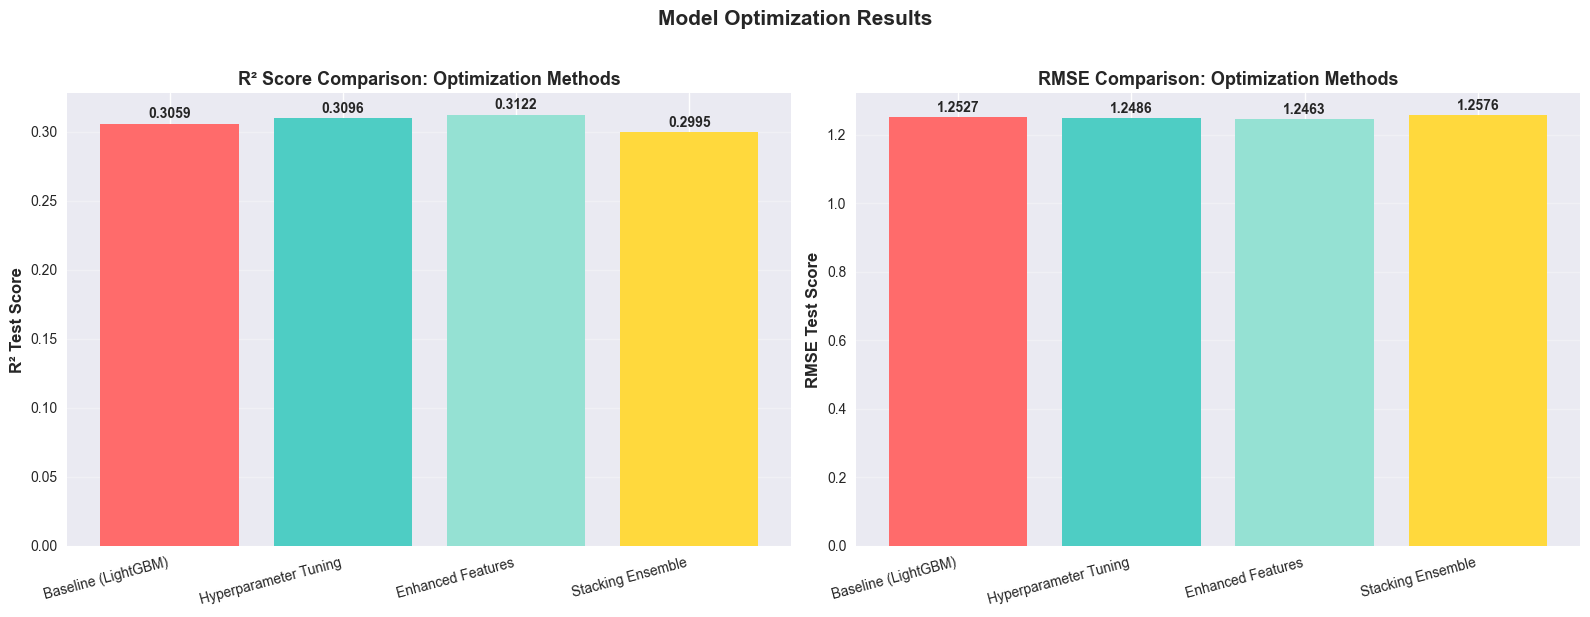


KẾT LUẬN:
 Best model: Enhanced Features
 R² Test: 0.3122 (cải thiện +2.04%)
 RMSE Test: 1.2463

 Khuyến nghị: Sử dụng Enhanced Features cho production model


In [16]:
# 2.4. So sánh kết quả tối ưu
print("=" * 90)
print("2.4. SO SÁNH KẾT QUẢ TỐI ƯU")
print("=" * 90)

# Tổng hợp kết quả
optimization_results = pd.DataFrame({
    'Method': [
        'Baseline (LightGBM)',
        'Hyperparameter Tuning',
        'Enhanced Features',
        'Stacking Ensemble'
    ],
    'R²_Test': [
        0.3059,  # Baseline
        r2_tune_test,
        r2_enhanced_test,
        r2_stack_test
    ],
    'RMSE_Test': [
        1.2527,  # Baseline
        rmse_tune_test,
        rmse_enhanced_test,
        rmse_stack_test
    ],
    'Improvement': [
        0.0000,
        r2_tune_test - 0.3059,
        r2_enhanced_test - 0.3059,
        r2_stack_test - 0.3059
    ]
})

optimization_results['Improvement_%'] = (optimization_results['Improvement'] / 0.3059 * 100).round(2)

print("\n" + optimization_results.to_string(index=False))

# Tìm best method
best_method = optimization_results.loc[optimization_results['R²_Test'].idxmax()]

print("\n" + "=" * 90)
print("BEST METHOD:")
print("=" * 90)
print(f"  Method: {best_method['Method']}")
print(f"  R² Test: {best_method['R²_Test']:.4f}")
print(f"  RMSE Test: {best_method['RMSE_Test']:.4f}")
print(f"  Improvement: {best_method['Improvement']:+.4f} ({best_method['Improvement_%']:+.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² Comparison
ax1 = axes[0]
ax1.bar(optimization_results['Method'], optimization_results['R²_Test'], 
        color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFD93D'])
ax1.set_ylabel('R² Test Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score Comparison: Optimization Methods', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticklabels(optimization_results['Method'], rotation=15, ha='right')

# Add value labels
for i, v in enumerate(optimization_results['R²_Test']):
    ax1.text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# RMSE Comparison
ax2 = axes[1]
ax2.bar(optimization_results['Method'], optimization_results['RMSE_Test'], 
        color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFD93D'])
ax2.set_ylabel('RMSE Test Score', fontsize=12, fontweight='bold')
ax2.set_title('RMSE Comparison: Optimization Methods', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(optimization_results['Method'], rotation=15, ha='right')

# Add value labels
for i, v in enumerate(optimization_results['RMSE_Test']):
    ax2.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Model Optimization Results', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


print("\n" + "=" * 90)
print("KẾT LUẬN:")
print("=" * 90)
print(f" Best model: {best_method['Method']}")
print(f" R² Test: {best_method['R²_Test']:.4f} (cải thiện {best_method['Improvement_%']:+.2f}%)")
print(f" RMSE Test: {best_method['RMSE_Test']:.4f}")
print(f"\n Khuyến nghị: Sử dụng {best_method['Method']} cho production model")
